# Final Project
Zhewei Shi

Deliverables:

1-You must create a simple web API to predict a user's BMI in real-time. You can also use webcam input. The goal is to use one of the pre-trained image models (e.g. VGG Face), fine-tune with the provided data, and deploy via jupyter notebook, streamlit, flask or any other simple restful api's.

2-10 pages of the write-up about your implementation.

3-10 mins presentation or live demo in the final lecture.

Our goal is to beat the performance metrics provided in the paper.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

In [2]:
img_dir = 'data.nosync/Images'
data_dir = 'data.nosync/data.csv'

data = pd.read_csv(data_dir)
data.drop('Unnamed: 0', axis=1, inplace=True)
print(data.shape)
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data.nosync/data.csv'

In [4]:
train = data[data['is_training'] == 1]
test = data[data['is_training'] == 0]
print(train.shape)
print(test.shape)

(3368, 4)
(838, 4)


In [5]:
import os
images = os.listdir(img_dir)
print(len(images)) # removed duplicate image: img_3827(1).img --> 3962

3963


Only leave the data with corresponding images

In [6]:
train = train.loc[train['name'].isin(images)]
test = test.loc[test['name'].isin(images)]
print(train.shape)
print(test.shape)

(3210, 4)
(752, 4)


In [7]:
y_train = train['bmi']
y_test = test['bmi']

In [8]:
data = pd.concat([train, test])
print(data.shape)
data.head()

(3962, 4)


,bmi,gender,is_training,name
0,34.207396,Male,1,img_0.bmp
1,26.453720,Male,1,img_1.bmp
2,34.967561,Female,1,img_2.bmp
3,22.044766,Female,1,img_3.bmp
6,25.845588,Female,1,img_6.bmp


In [9]:
import shutil
train_dir = 'data.nosync/train'
test_dir = 'data.nosync/test'

# for name in train['name']:
#     src = img_dir + '/' + name
#     shutil.copy(src, train_dir)

# for name in test['name']:
#     src = img_dir + '/' + name
#     shutil.copy(src, test_dir)

## Images

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.utils import load_img, img_to_array, image_dataset_from_directory, array_to_img
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import Sequential
from keras import layers

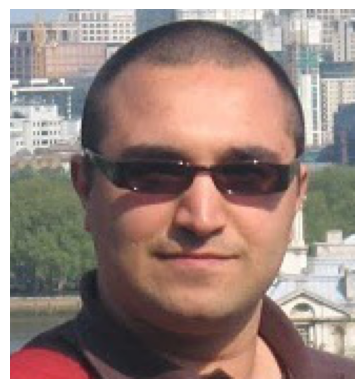

In [11]:
input_img_paths = sorted(
    [os.path.join(train_dir, fname)
     for fname in os.listdir(train_dir)
     if fname.endswith(".bmp")])

test_img_paths = sorted(
    [os.path.join(test_dir, fname)
     for fname in os.listdir(test_dir)
     if fname.endswith(".bmp")])

plt.axis("off")
plt.imshow(load_img(input_img_paths[0]));

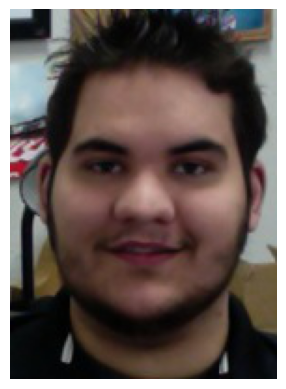

In [12]:
plt.axis("off")
plt.imshow(load_img(input_img_paths[5]));

In [13]:
img_size = (224,224)
num_train_imgs = len(os.listdir(train_dir))
num_test_imgs = len(os.listdir(test_dir))

In [213]:
# def path_to_input_image(path):
#     return img_to_array(load_img(path, target_size=img_size))

# input_imgs = np.zeros((num_train_imgs,) + img_size + (3,), dtype="float32")
# for i in range(num_train_imgs):
#     input_imgs[i] = path_to_input_image(input_img_paths[i])

# test_imgs = np.zeros((num_test_imgs,) + img_size + (3,), dtype="float32")
# for i in range(num_test_imgs):
#     test_imgs[i] = path_to_input_image(test_img_paths[i])

In [215]:
# print(input_imgs.shape)
# print(test_imgs.shape)

(3210, 224, 224, 3)
(752, 224, 224, 3)


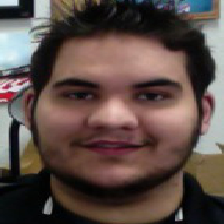

In [216]:
# array_to_img(input_imgs[5])

### Correctly scale image

In [14]:
from PIL import Image, ImageOps

def process_img(path, size = 224):
    desired_size = size
    im_pth = path

    im = Image.open(im_pth)
    old_size = im.size  # old_size[0] is in (width, height) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # use thumbnail() or resize() method to resize the input image

    # thumbnail is a in-place operation

    # im.thumbnail(new_size, Image.ANTIALIAS)

    im = im.resize(new_size, Image.LANCZOS)
    # create a new image and paste the resized on it

    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))

    new_im_arr = img_to_array(new_im)
    return new_im_arr

In [15]:
input_imgs = np.zeros((num_train_imgs,) + img_size + (3,), dtype="float32")
for i in range(num_train_imgs):
    input_imgs[i] = process_img(input_img_paths[i])

test_imgs = np.zeros((num_test_imgs,) + img_size + (3,), dtype="float32")
for i in range(num_test_imgs):
    test_imgs[i] = process_img(test_img_paths[i])

print(input_imgs.shape)
print(test_imgs.shape)

(3210, 224, 224, 3)
(752, 224, 224, 3)


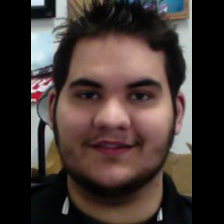

In [16]:
array_to_img(input_imgs[5])

## NN

In [17]:
# %pip install keras_vggface
# https://github.com/rcmalli/keras-vggface/issues/73 solves ModuleNotFoundError
# /Users/shizhewei/miniconda3/lib/python3.10/site-packages/keras_vggface/models.py
import keras_vggface
from keras_vggface.vggface import VGGFace

In [18]:
def define_model(vgg_model = 'vgg16'):

    if vgg_model == 'vgg16':
        vgg_face = VGGFace(model=vgg_model, include_top=True, input_shape=(224,224,3))
        vgg_last_layer = vgg_face.get_layer('fc6').output
        vgg_flatten = layers.Activation('relu')(vgg_last_layer)
    else:
        vgg_face = VGGFace(model=vgg_model, include_top=False, input_shape=(224,224,3))
        vgg_last_layer = vgg_face.output
        vgg_flatten = layers.Flatten()(vgg_last_layer)

    # transfer learning
    for layer in vgg_face.layers:
        layer.trainable = False

    x = layers.Dense(128)(vgg_flatten)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    bmi_out = layers.Dense(1, activation='linear', name='bmi')(x)

    face2bmi = Model(vgg_face.input, bmi_out)

    face2bmi.compile(optimizer='adam', loss='mae')

    return face2bmi

face2bmi = define_model()
face2bmi.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                              

### VGG16

In [33]:
es = EarlyStopping(patience=3)
ckp = ModelCheckpoint('face2bmi.h5', save_best_only=True, save_weights_only=True, verbose=1)
callbacks = [es, ckp]

face2bmi.fit(input_imgs, y_train, batch_size=128, epochs=30, validation_split=0.2, callbacks=callbacks)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 32.2382
Epoch 1: val_loss improved from inf to 36.70933, saving model to face2bmi.h5
21/21 [==============================] - 36s 2s/step - loss: 32.2382 - val_loss: 36.7093
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 31.8624
Epoch 2: val_loss improved from 36.70933 to 36.20881, saving model to face2bmi.h5
21/21 [==============================] - 31s 1s/step - loss: 31.8624 - val_loss: 36.2088
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 31.5449
Epoch 3: val_loss improved from 36.20881 to 34.15675, saving model to face2bmi.h5
21/21 [==============================] - 31s 1s/step - loss: 31.5449 - val_loss: 34.1568
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 31.1381
Epoch 4: val_loss improved from 34.15675 to 33.85249, saving model to face2bmi.h5
21/21 [==============================] - 30s 1s/step - loss: 31.1381 - val_loss: 33.8525
Epoch 5/30
21/21 

#### Evaluation

In [34]:
face2bmi.evaluate(test_imgs, y_test, batch_size=128)

6/6 [==============================] - 7s 1s/step - loss: 7.7315


7.73150110244751

In [35]:
bmi_pred = face2bmi.predict(test_imgs)
bmi_pred = bmi_pred.reshape(-1)

24/24 [==============================] - 7s 299ms/step


In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(f'Test RMSE = {mean_squared_error(y_test, bmi_pred)**0.5}')
print(f'Test MAE = {mean_absolute_error(y_test, bmi_pred)}')

Test RMSE = 10.054097063473458
Test MAE = 7.731500956758005


### RESNET50

In [19]:
face2bmi_resnet = define_model(vgg_model='resnet50')
face2bmi_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                           

In [22]:
es = EarlyStopping(patience=3)
ckp_resnet = ModelCheckpoint('face2bmi_resnet.h5', save_best_only=True, save_weights_only=True, verbose=1)

face2bmi_resnet.fit(input_imgs, y_train, batch_size=128, epochs=30, validation_split=0.2, callbacks=[es, ckp_resnet])

Epoch 1/30


2023-05-03 20:32:12.440816: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


21/21 [==============================] - ETA: 0s - loss: 32.1967
Epoch 1: val_loss improved from inf to 33.48888, saving model to face2bmi_resnet.h5
21/21 [==============================] - 19s 768ms/step - loss: 32.1967 - val_loss: 33.4889
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 31.9324
Epoch 2: val_loss improved from 33.48888 to 33.18855, saving model to face2bmi_resnet.h5
21/21 [==============================] - 15s 706ms/step - loss: 31.9324 - val_loss: 33.1885
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 31.5325
Epoch 3: val_loss improved from 33.18855 to 33.14305, saving model to face2bmi_resnet.h5
21/21 [==============================] - 14s 672ms/step - loss: 31.5325 - val_loss: 33.1430
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 31.0272
Epoch 4: val_loss improved from 33.14305 to 31.89355, saving model to face2bmi_resnet.h5
21/21 [==============================] - 14s 669ms/step - loss: 31.0272 - val_lo

#### Evaluation

In [23]:
face2bmi_resnet.evaluate(test_imgs, y_test, batch_size=128)

6/6 [==============================] - 4s 565ms/step - loss: 7.1588


7.158768653869629

In [24]:
bmi_pred_resnet = face2bmi_resnet.predict(test_imgs).reshape(-1)

24/24 [==============================] - 4s 141ms/step


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(f'Test RMSE = {mean_squared_error(y_test, bmi_pred_resnet)**0.5}')
print(f'Test MAE = {mean_absolute_error(y_test, bmi_pred_resnet)}')

Test RMSE = 9.526575215464085
Test MAE = 7.15876841602587


In [27]:
from scipy.stats import pearsonr
pearsonr(y_test, bmi_pred_resnet)

PearsonRResult(statistic=0.10698998168958136, pvalue=0.003308698893083747)

Text(0, 0.5, 'Predicted')

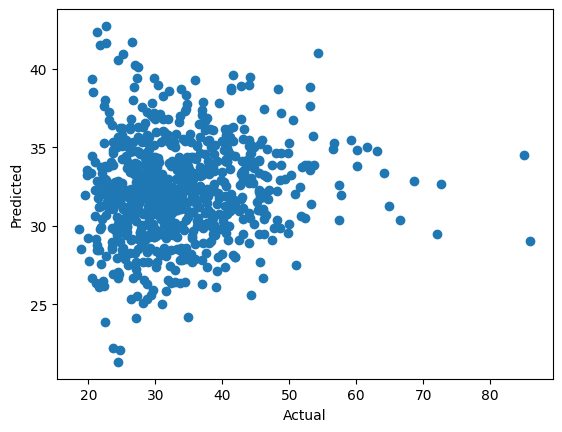

In [28]:
plt.scatter(y_test, bmi_pred_resnet)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [177]:
y_test[y_test>80]

4008    84.984889
4180    85.987061
Name: bmi, dtype: float64

In [178]:
test.loc[4008]

bmi               84.984889
gender                 Male
is_training               0
name           img_4008.bmp
Name: 4008, dtype: object

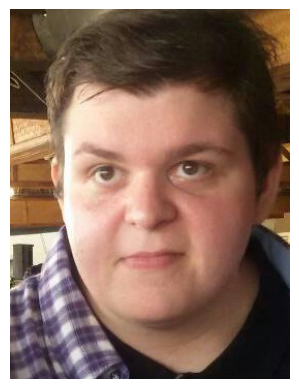

In [29]:
plt.axis("off")
plt.imshow(load_img(test_img_paths[test_img_paths.index('data.nosync/test/img_4008.bmp')]));

In [30]:
test_img_paths.index('data.nosync/test/img_4008.bmp')

565

In [31]:
bmi_pred_resnet[565]

34.500607

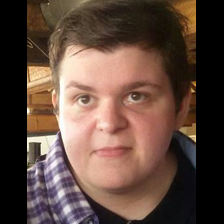

In [32]:
array_to_img(test_imgs[565])

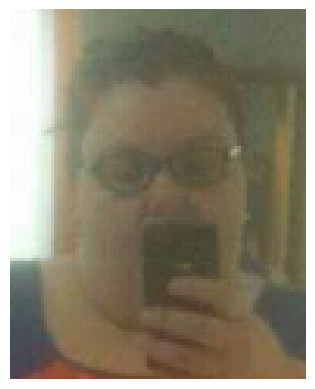

In [37]:
plt.axis("off")
plt.imshow(load_img(test_img_paths[test_img_paths.index('data.nosync/test/img_4180.bmp')]));

In [41]:
test2 = test.copy()

test2['predict'] = bmi_pred
test2['resid'] = test2['bmi'] -test2['predict'] 
test2

,bmi,gender,is_training,name,predict,resid
3369,29.698495,Male,0,img_3369.bmp,32.437359,-2.738863
3370,30.845918,Female,0,img_3370.bmp,36.934338,-6.088419
3371,24.389796,Female,0,img_3371.bmp,34.265839,-9.876043
3372,36.258679,Male,0,img_3372.bmp,35.813847,0.444832
3373,27.891291,Male,0,img_3373.bmp,30.350237,-2.458945
...,...,...,...,...,...,...
4201,34.078947,Male,0,img_4201.bmp,29.785118,4.293829
4202,34.564776,Female,0,img_4202.bmp,36.134731,-1.569955
4203,27.432362,Female,0,img_4203.bmp,31.665907,-4.233545
4204,40.492800,Male,0,img_4204.bmp,39.243710,1.249090


<Axes: >

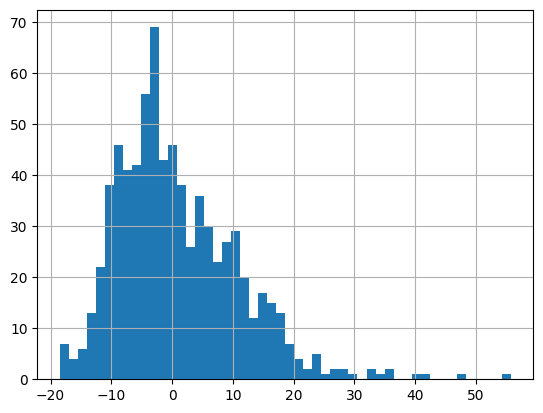

In [42]:
test2['resid'].hist(bins=50)

In [43]:
test2[test2['resid']>40]

,bmi,gender,is_training,name,predict,resid
4008,84.984889,Male,0,img_4008.bmp,38.056820,46.928069
4180,85.987061,Female,0,img_4180.bmp,30.217714,55.769346
4181,72.084961,Female,0,img_4181.bmp,31.005323,41.079638


In [102]:
### Add Sex (not working)
# def define_model(vgg_model = 'vgg16'):

#     if vgg_model == 'vgg16':
#         vgg_face = VGGFace(model=vgg_model, include_top=True, input_shape=(224,224,3))
#         vgg_last_layer = vgg_face.get_layer('fc6').output
#         vgg_flatten = layers.Activation('relu')(vgg_last_layer)
#     else:
#         vgg_face = VGGFace(model=vgg_model, include_top=False, input_shape=(224,224,3))
#         vgg_last_layer = vgg_face.output
#         vgg_flatten = layers.Flatten()(vgg_last_layer)

#     # transfer learning
#     for layer in vgg_face.layers:
#         layer.trainable = False

#     def block(flatten, name):
#         x = layers.Dense(128)(vgg_flatten)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation('relu')(x)
#         x = layers.Dropout(0.5)(x)
#         x = layers.Dense(128)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation('relu')(x)
#         x = layers.Dropout(0.5)(x)
#         return x

#     x_sex = block(vgg_flatten, name = 'sex')
#     out_sex = layers.Dense(1, activation = 'relu', name = 'sex')(x_sex)       

#     x_bmi = layers.Dense(128)(vgg_flatten)
#     x_bmi = layers.Add()([x_bmi, x_sex])
#     x_bmi = block(x_bmi, name = 'age')
#     out_bmi = layers.Dense(1, activation='linear', name='bmi')(x_bmi)

#     face2bmi = Model(vgg_face.input, [out_sex, out_bmi])

#     face2bmi.compile('adam', 
#                      {'bmi': 'mae', 'sex':'binary_crossentropy'}, 
#                      {'sex':'accuracy'},
#                      loss_weights={'bmi':0.9, 'sex':0.1})

#     return face2bmi

# face2bmi_2 = define_model()
# face2bmi_2.summary()

# es = EarlyStopping(patience=4)
# ckp = ModelCheckpoint('face2bmi_2.h5', save_best_only=True, save_weights_only=True, verbose=1)
# callbacks = [es, ckp]

# face2bmi_2.fit(input_imgs, y_train, batch_size=128, epochs=30, validation_split=0.2, callbacks=callbacks)

## VGG features & Regression

#### Original VGG features

In [48]:
def vgg_conv_features(model):
    if model == 'vgg16':
        vgg_features = VGGFace(model = model, include_top=True, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max
    else:
        vgg_features = VGGFace(model = model, include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max
    return vgg_features

def vgg_layer_features(model, layer):
    vgg_model = vgg_conv_features(model)
    if model == 'vgg16':
        out = vgg_model.get_layer(layer).output
        vgg_model_new = Model(vgg_model.input, out)
    else:
        out = vgg_model.output
        vgg_model_new = Model(vgg_model.input, out)
    return vgg_model_new

In [78]:
basic_vgg = vgg_conv_features('vgg16')
X_train_basic = basic_vgg.predict(input_imgs)
X_test_basic = basic_vgg.predict(test_imgs)
print(X_train_basic.shape)
print(X_test_basic.shape)

24/24 [==============================] - 8s 327ms/step
(3210, 2622)
(752, 2622)


In [103]:
basic_resnet = vgg_conv_features('resnet50')
X_train_basic_resnet = basic_resnet.predict(input_imgs)
X_test_basic_resnet = basic_resnet.predict(test_imgs)
print(X_train_basic_resnet.shape)
print(X_test_basic_resnet.shape)

24/24 [==============================] - 5s 189ms/step
(3210, 2048)
(752, 2048)


#### Custom VGG features

In [63]:
def finetuned_vgg(model = 'vgg16'):

    if model == 'vgg16':
        vgg_face = VGGFace(model=model, include_top=True, input_shape=(224,224,3))

        # transfer learning
        for layer in vgg_face.layers:
            layer.trainable = False

        last_layer = vgg_face.get_layer('pool5').output
        x = layers.Flatten(name='flatten')(last_layer)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(128, activation='relu', name='fc6')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(128, activation='relu', name='fc7')(x)
        x = layers.BatchNormalization()(x)
        out = layers.Flatten(name='flatten_out')(x)
        custom_vgg_model = Model(vgg_face.input, out)
        return custom_vgg_model

    else:
        vgg_face = VGGFace(model=model, include_top=False, input_shape=(224,224,3))

        # transfer learning
        for layer in vgg_face.layers:
            layer.trainable = False

        last_layer = vgg_face.get_layer('avg_pool').output
        x = layers.Flatten(name='flatten')(last_layer)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(128, activation='relu', name='fc6')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(128, activation='relu', name='fc7')(x)
        x = layers.BatchNormalization()(x)
        out = layers.Flatten(name='flatten_out')(x)
        custom_vgg_model = Model(vgg_face.input, out)
        return custom_vgg_model

In [79]:
custom_vgg_model = finetuned_vgg('vgg16')

X_train_custom = custom_vgg_model.predict(input_imgs)
X_test_custom = custom_vgg_model.predict(test_imgs)
print(X_train_custom.shape)
print(X_test_custom.shape)

24/24 [==============================] - 8s 357ms/step
(3210, 128)
(752, 128)


In [104]:
custom_resnet_model = finetuned_vgg('resnet50')

X_train_custom_resnet = custom_resnet_model.predict(input_imgs)
X_test_custom_resnet = custom_resnet_model.predict(test_imgs)
print(X_train_custom_resnet.shape)
print(X_test_custom_resnet.shape)

24/24 [==============================] - 5s 203ms/step
(3210, 128)
(752, 128)


#### Regression

In [94]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

##### SVR using VGG16 (original)

In [91]:
param_dist = {
    'C': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
    'epsilon': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
}

random_search = RandomizedSearchCV(
    SVR(kernel='rbf'),
    param_distributions=param_dist,
    scoring='neg_mean_absolute_error'
)

random_search.fit(X_train_basic, y_train)

print('Best hyperparameters:', random_search.best_params_)
print('Best score:', random_search.best_score_)

Best hyperparameters: {'epsilon': 0.9, 'C': 0.01}
Best score: -6.224635705806513


In [92]:
svr_vgg_basic = random_search.best_estimator_
svr_vgg_basic_pred = svr_vgg_basic.predict(X_test_basic)

mean_absolute_error(y_test, svr_vgg_basic_pred)

7.063767053856994

In [108]:
svr_vgg_basic = SVR(kernel='rbf', C=0.01, epsilon=0.9)
svr_vgg_basic.fit(X_train_basic, y_train)
svr_vgg_basic_pred = svr_vgg_basic.predict(X_test_basic)

mean_absolute_error(y_test, svr_vgg_basic_pred)

7.063767053856994

##### Random Forest using VGG16 (original)

In [100]:
rf_vgg_basic = RandomForestRegressor(n_estimators=200, max_depth=8)
rf_vgg_basic.fit(X_train_basic, y_train)
rf_vgg_basic_pred = rf_vgg_basic.predict(X_test_basic)

In [101]:
mean_absolute_error(y_test, rf_vgg_basic_pred)

7.1086394037612415

##### SVR using RESNET (original)

In [105]:
param_dist = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1],
    'epsilon': [0.8, 0.9, 1, 1.1, 1.2],
}

random_search = RandomizedSearchCV(
    SVR(kernel='rbf'),
    param_distributions=param_dist,
    scoring='neg_mean_absolute_error'
)

random_search.fit(X_train_basic_resnet, y_train)

print('Best hyperparameters:', random_search.best_params_)
print('Best score:', random_search.best_score_)

Best hyperparameters: {'epsilon': 0.9, 'C': 0.001}
Best score: -6.223679011732735


In [106]:
svr_vgg_basic_resnet = random_search.best_estimator_
svr_vgg_basic_resnet_pred = svr_vgg_basic_resnet.predict(X_test_basic_resnet)

mean_absolute_error(y_test, svr_vgg_basic_resnet_pred)

7.063249366533738

##### Random Forest using RESNET (original)

In [109]:
rf_vgg_basic_resnet = RandomForestRegressor(n_estimators=200, max_depth=8)
rf_vgg_basic_resnet.fit(X_train_basic_resnet, y_train)
rf_vgg_basic_resnet_pred = rf_vgg_basic_resnet.predict(X_test_basic_resnet)

In [110]:
mean_absolute_error(y_test, rf_vgg_basic_resnet_pred)

7.076493758160773

##### SVR using VGG16 (custom)

In [111]:
param_dist = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1],
    'epsilon': [0.8, 0.9, 1, 1.1, 1.2],
}

random_search = RandomizedSearchCV(
    SVR(kernel='rbf'),
    param_distributions=param_dist,
    scoring='neg_mean_absolute_error'
)

random_search.fit(X_train_custom, y_train)

print('Best hyperparameters:', random_search.best_params_)
print('Best score:', random_search.best_score_)

Best hyperparameters: {'epsilon': 0.8, 'C': 0.001}
Best score: -6.224242481122154


In [112]:
svr_vgg_custom = random_search.best_estimator_
svr_vgg_custom_pred = svr_vgg_custom.predict(X_test_custom)

mean_absolute_error(y_test, svr_vgg_custom_pred)

7.061100231802106

##### Random Forest using VGG16 (custom)

In [113]:
rf_vgg_custom = RandomForestRegressor(n_estimators=200, max_depth=8)
rf_vgg_custom.fit(X_train_custom, y_train)
rf_vgg_custom_pred = rf_vgg_custom.predict(X_test_custom)

In [114]:
mean_absolute_error(y_test, rf_vgg_custom_pred)

7.093442172518766

##### SVR using RESNET (custom)

In [115]:
param_dist = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1],
    'epsilon': [0.8, 0.9, 1, 1.1, 1.2],
}

random_search = RandomizedSearchCV(
    SVR(kernel='rbf'),
    param_distributions=param_dist,
    scoring='neg_mean_absolute_error'
)

random_search.fit(X_train_custom_resnet, y_train)

print('Best hyperparameters:', random_search.best_params_)
print('Best score:', random_search.best_score_)

Best hyperparameters: {'epsilon': 0.9, 'C': 0.001}
Best score: -6.223708072437285


In [116]:
svr_vgg_custom_resnet = random_search.best_estimator_
svr_vgg_custom_resnet_pred = svr_vgg_custom_resnet.predict(X_test_custom_resnet)

mean_absolute_error(y_test, svr_vgg_custom_resnet_pred)

7.063048989929558

##### Random Forest using RESNET (custom)

In [117]:
rf_vgg_custom_resnet = RandomForestRegressor()
rf_vgg_custom_resnet.fit(X_train_custom_resnet, y_train)
rf_vgg_custom_resnet_pred = rf_vgg_custom_resnet.predict(X_test_custom_resnet)

In [118]:
mean_absolute_error(y_test, rf_vgg_custom_resnet_pred)

7.24658789900119

#### SVR & RESNET & Original

In [119]:
param_dist = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.001, 0.005, 0.01, 0.015],
    'epsilon': [0.8, 0.9, 1, 1.1, 1.2],
}

random_search = RandomizedSearchCV(
    SVR(),
    param_distributions=param_dist,
    scoring='neg_mean_absolute_error'
)

random_search.fit(X_train_basic_resnet, y_train)

print('Best hyperparameters:', random_search.best_params_)
print('Best score:', random_search.best_score_)

Best hyperparameters: {'kernel': 'rbf', 'epsilon': 1, 'C': 0.001}
Best score: -6.223738009837158


In [121]:
best_model = random_search.best_estimator_

y_pred = best_model.prebdict(X_test_basic_resnet)

mean_absolute_error(y_test, y_pred)

7.06265767156673